# Computer Vision - MIA


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Objective

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. Your goal is to complete the given code without changing the base architecture of VGG-16 (other than replacing the classification head suitable for binary classification).


**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---
IN CASE CELEBA DATASET IS NOT AVAILABLE YOU SHOULD USE THE DATASET OF YOUR FINAL PROJECT.

---

## Task
You will:
- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

##1) Initialize

*   Mke a copy of the notebook.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [1]:
# load data
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

/home/kainak0_pc/gitProjects/mia/mia-303_vision/img_align_celeba/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/kainak0_pc/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [3]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [4]:
path_csv = os.path.join(path,"list_attr_celeba.csv")  #'/content/drive/My Drive/CelebA30k.csv'
data = pd.read_csv(path_csv) # enter the file path on your drive for the csv file
data.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
gender_data = data[['image_id', 'Male']].copy()
gender_data.head()

,image_id,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [6]:
# !unzip "/content/drive/My Drive/archive.zip" -d "/content/data"

In [7]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

# !unzip "/content/drive/My Drive/archive.zip" -d "/content/data"

In [8]:
path_img = os.path.join(path,"img_align_celeba/img_align_celeba/")
first_image_path = os.path.join(path_img, gender_data.loc[0,"image_id"])
img = Image.open(first_image_path)

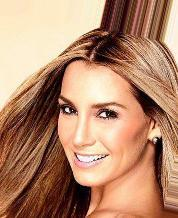

In [9]:
img

# Starting here, you’ll need to fill in the code cells on your own.

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


In [10]:
print(len(gender_data))

202599


In [ ]:
from sklearn.model_selection import train_test_split

# Get 20% sample, stratified by category
sampled_df, _ = train_test_split(gender_data, test_size=0.8, stratify=gender_data['Male'], random_state=42)
gender_data = sampled_df.reset_index(drop=True)
print(f"Cantidad total de imagenes reducidad a: {len(sampled_df)}")
print(f"Cantidad Hombres:{len(sampled_df[sampled_df['Male'] == 1])}")
print(f"Cantidad Mujeres:{len(sampled_df[sampled_df['Male'] == -1])}")

Cantidad total de imagenes reducidad a: 40519
Cantidad Hombres:16886
Cantidad Mujeres:23633


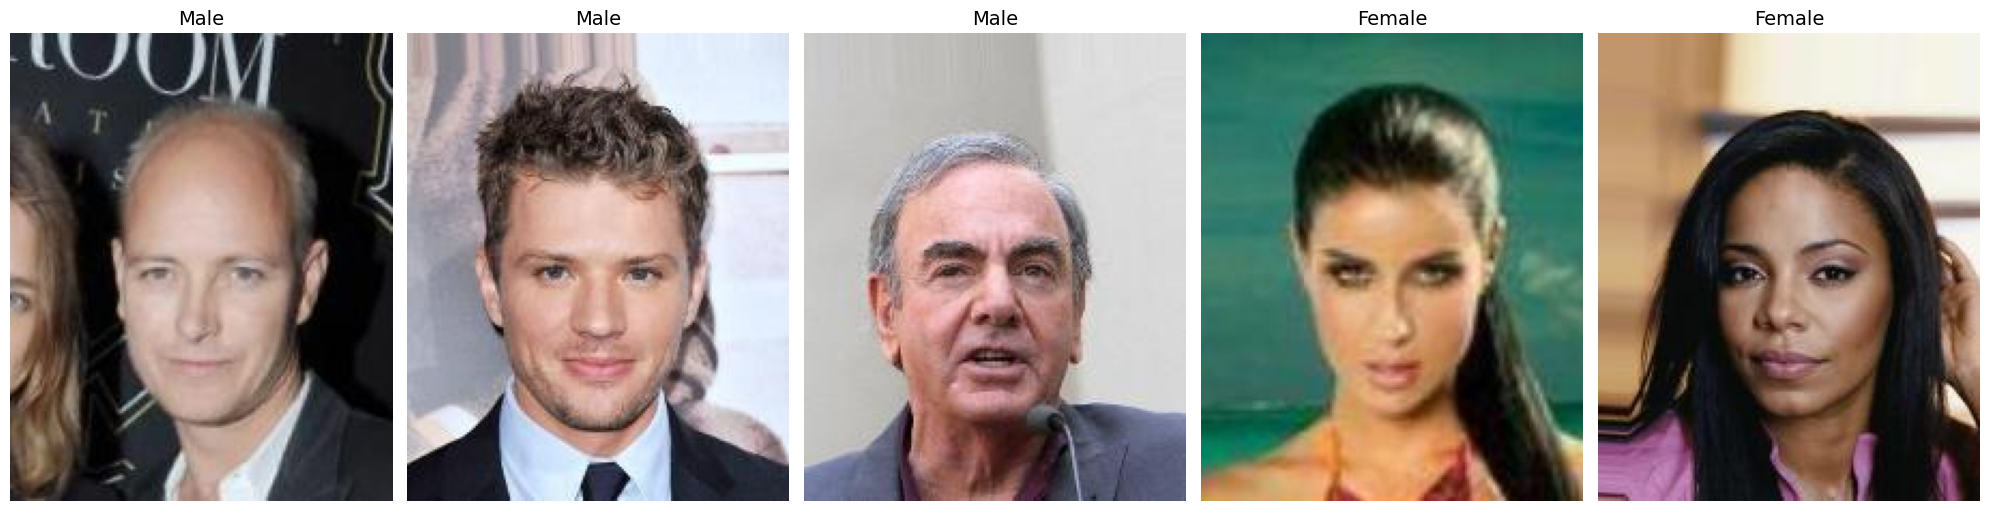



Number of Males: 16886 (41.67%)
Number of Females: 23633 (58.33%)


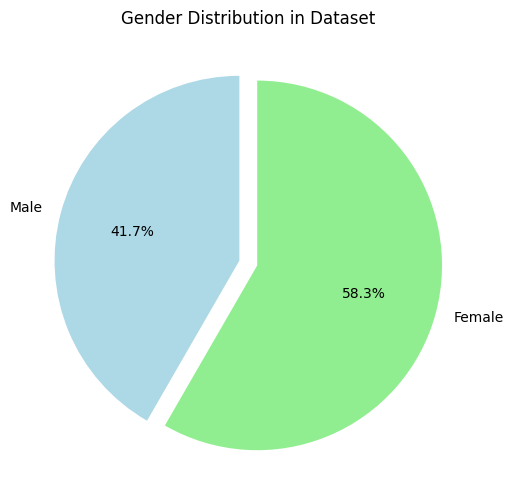

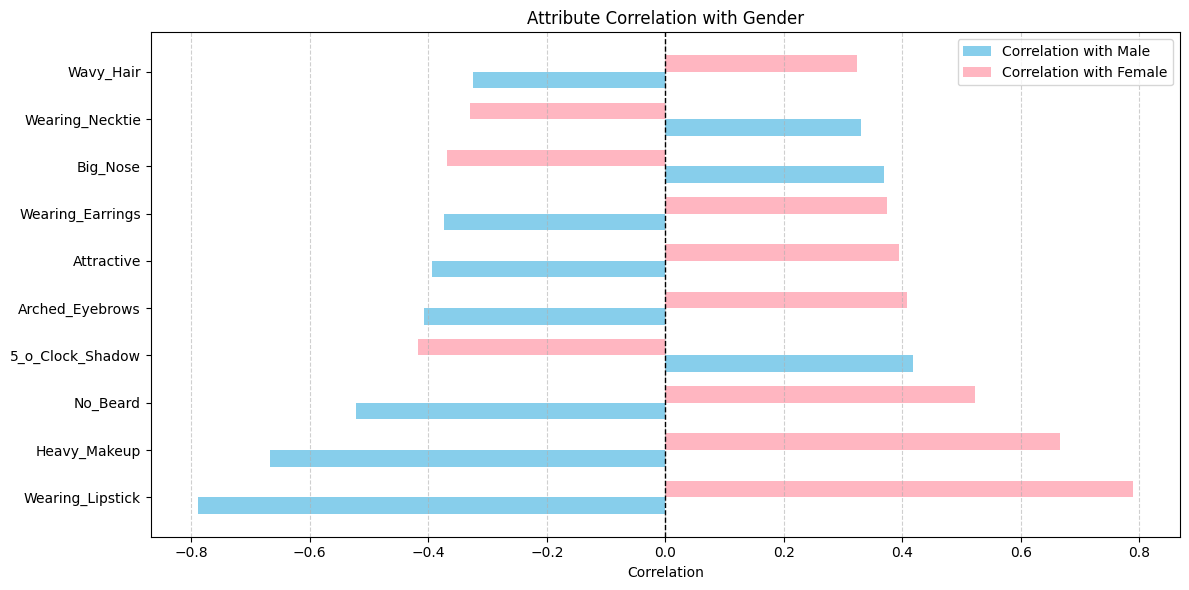

In [12]:
random_indices = np.random.choice(len(gender_data), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, ax in zip(random_indices, axes):
    img_path = os.path.join(path_img, gender_data.loc[idx, "image_id"])
    img = Image.open(img_path)

    ax.imshow(img)
    ax.axis('off')

    label = "Male" if gender_data.loc[idx, "Male"] == 1 else "Female"
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.show()
print("")
print("")
# calculate the distribution of labels
label_counts = gender_data['Male'].value_counts()
label_percentages = gender_data['Male'].value_counts(normalize=True) * 100

label_names = {1: 'Male', -1: 'Female'}
print(f"Number of Males: {label_counts.get(1, 0)} ({label_percentages.get(1, 0):.2f}%)")
print(f"Number of Females: {label_counts.get(-1, 0)} ({label_percentages.get(-1, 0):.2f}%)")


plt.figure(figsize=(6,6))
plt.pie(
    [label_counts.get(1, 0), label_counts.get(-1, 0)],
    labels=['Male', 'Female'],
    autopct='%1.1f%%',
    colors=['lightblue', 'lightgreen'],
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title("Gender Distribution in Dataset")
plt.show()
# Drop 'filename' to keep only numerical attributes
attribute_corr = data.drop(columns='image_id').corr()

# Correlation with 'Male'
male_corr = attribute_corr['Male'].drop('Male').sort_values()

# Correlation with 'Female' is just negative of 'Male' column
female_corr = -male_corr  # Flip sign

import matplotlib.pyplot as plt

# Take top 10 absolute correlations for both
import matplotlib.pyplot as plt
import numpy as np

# Take top 10 attributes most correlated (absolute) with gender
top_attrs = male_corr.abs().sort_values(ascending=False).head(10).index

# Get values
male_values = male_corr[top_attrs].values
female_values = -male_values  # inverse of male correlation

x = np.arange(len(top_attrs))
width = 0.35
print("")
print("")
plt.figure(figsize=(12, 6))
plt.barh(x - width/2, male_values, height=width, color='skyblue', label='Correlation with Male')
plt.barh(x + width/2, female_values, height=width, color='lightpink', label='Correlation with Female')
plt.yticks(x, top_attrs)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Correlation")
plt.title("Attribute Correlation with Gender")
plt.legend()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [13]:
from sklearn.model_selection import train_test_split
# First split: separate train (80%) from temp (20%)

val_size = 0.1
test_size = 0.1
random_state = 42

X = gender_data['image_id']
y = gender_data['Male']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), 
                                                    random_state=random_state, 
                                                    stratify=y
    )
    
    # Second split: split temp (20%) into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(val_size + test_size),
                                                random_state=random_state, stratify=y_temp
)


# Your code here

In [14]:
train_data = pd.concat([X_train,y_train], axis=1).reset_index(drop=True)

In [15]:
val_data = pd.concat([X_val,y_val], axis=1).reset_index(drop=True)

## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [16]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader

class CelebADataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_id']
        label = self.dataframe.iloc[idx]['Male']
        label = 1 if label == 1 else 0

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

img_dir = path_img

train_dataset = CelebADataset(train_data[['image_id', 'Male']], img_dir, transform=train_transforms)
val_dataset = CelebADataset(val_data[['image_id', 'Male']], img_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [17]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),

    nn.Linear(4096, 1)
)

model = model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.


In [18]:
def calculate_accuracy(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred > 0.5
    correct = (y_pred.squeeze().long() == y_true).sum()
    acc = correct.item() / len(y_true)
    return acc

In [19]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += calculate_accuracy(outputs, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, labels)

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_acc / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [20]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt

configs = [
    {"strategy": "frozen", "lr": 0.001},
    {"strategy": "frozen", "lr": 0.0001},
    {"strategy": "last_block", "lr": 0.001},
    {"strategy": "last_block", "lr": 0.0001},
]

# Estructuras separadas para cada estrategia
results_frozen = {}
results_last_block = {}

for config in configs:
    print("\n" + "=" * 60)
    print(f"Running config: strategy={config['strategy']}  lr={config['lr']}")
    print("=" * 60)

    # 1) Cargar el modelo preentrenado
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

    # 2) Congelar todo el backbone
    for param in model.features.parameters():
        param.requires_grad = False

    # 3) Reemplazar el classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1),
    )

    # 4) Descongelar el último bloque si corresponde
    if config["strategy"] == "last_block":
        for param in model.features[24:].parameters():
            param.requires_grad = True

    model = model.to(device)

    # 5) Definir criterio y optimizador
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    # 6) Entrenar y evaluar
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
        model, train_loader, val_loader, criterion, optimizer, device, epochs=10
    )

    # 7) Guardar resultados en la estructura correspondiente
    if config["strategy"] == "frozen":
        results_frozen[config["lr"]] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "model": model.state_dict()  # guarda el modelo entrenado
        }
    else:
        results_last_block[config["lr"]] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "model": model.state_dict()
        }

    print(f"\nFinal Training Acc: {train_accuracies[-1]:.4f} | Final Val Acc: {val_accuracies[-1]:.4f}")


Running config: strategy=frozen  lr=0.001
Epoch 1/10, Train Loss: 0.2621, Train Acc: 0.9221, Val Loss: 0.1494, Val Acc: 0.9412
Epoch 2/10, Train Loss: 0.1467, Train Acc: 0.9460, Val Loss: 0.1460, Val Acc: 0.9390
Epoch 3/10, Train Loss: 0.1321, Train Acc: 0.9518, Val Loss: 0.1579, Val Acc: 0.9460
Epoch 4/10, Train Loss: 0.1151, Train Acc: 0.9599, Val Loss: 0.1345, Val Acc: 0.9465
Epoch 5/10, Train Loss: 0.1132, Train Acc: 0.9609, Val Loss: 0.1714, Val Acc: 0.9475
Epoch 6/10, Train Loss: 0.1020, Train Acc: 0.9665, Val Loss: 0.1556, Val Acc: 0.9517
Epoch 7/10, Train Loss: 0.0963, Train Acc: 0.9674, Val Loss: 0.1657, Val Acc: 0.9446
Epoch 8/10, Train Loss: 0.0936, Train Acc: 0.9716, Val Loss: 0.1823, Val Acc: 0.9448
Epoch 9/10, Train Loss: 0.0892, Train Acc: 0.9727, Val Loss: 0.1921, Val Acc: 0.9482
Epoch 10/10, Train Loss: 0.0819, Train Acc: 0.9736, Val Loss: 0.1688, Val Acc: 0.9531

Final Training Acc: 0.9736 | Final Val Acc: 0.9531

Running config: strategy=frozen  lr=0.0001
Epoch 1/10

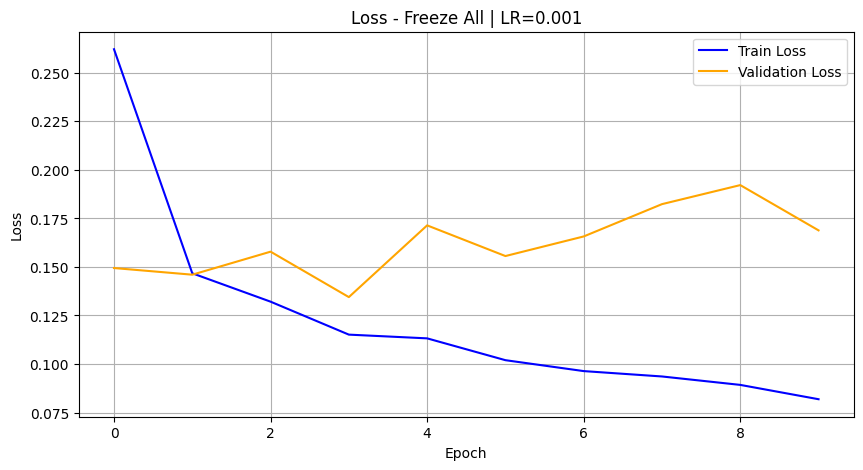

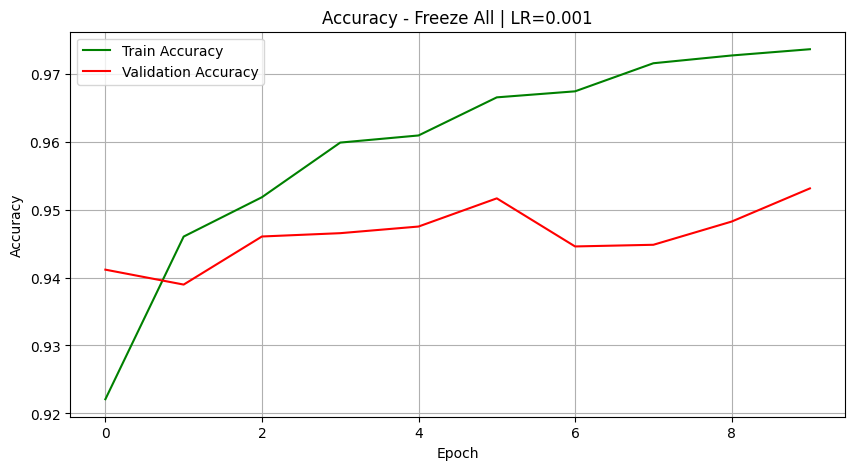

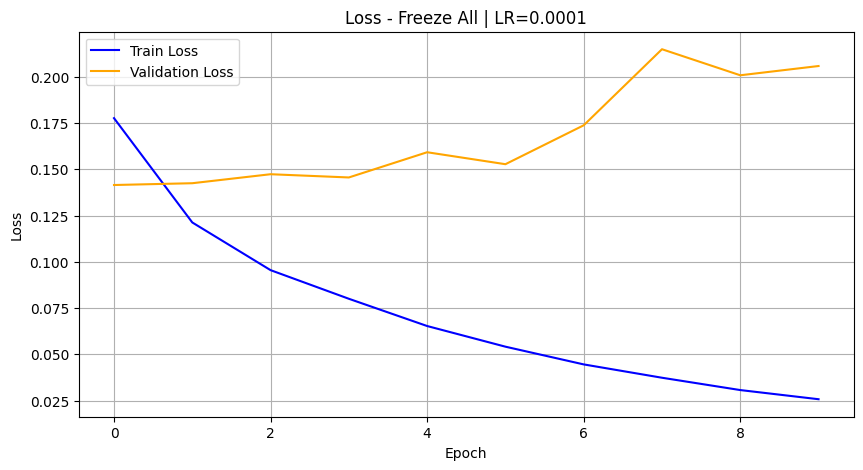

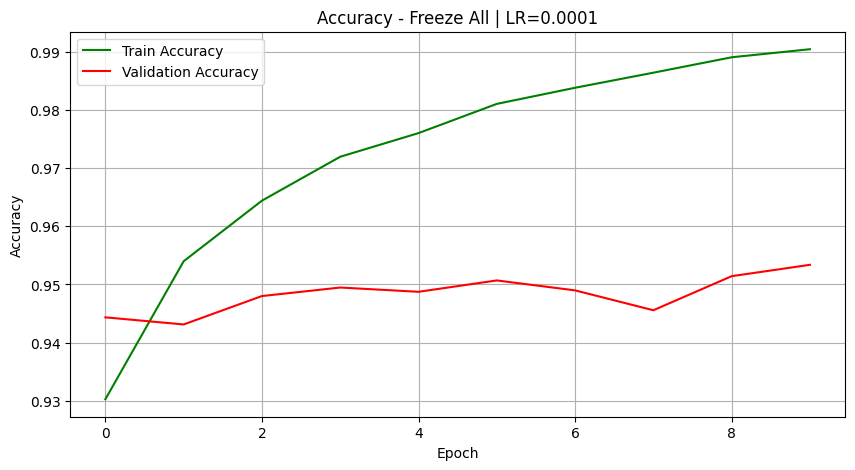

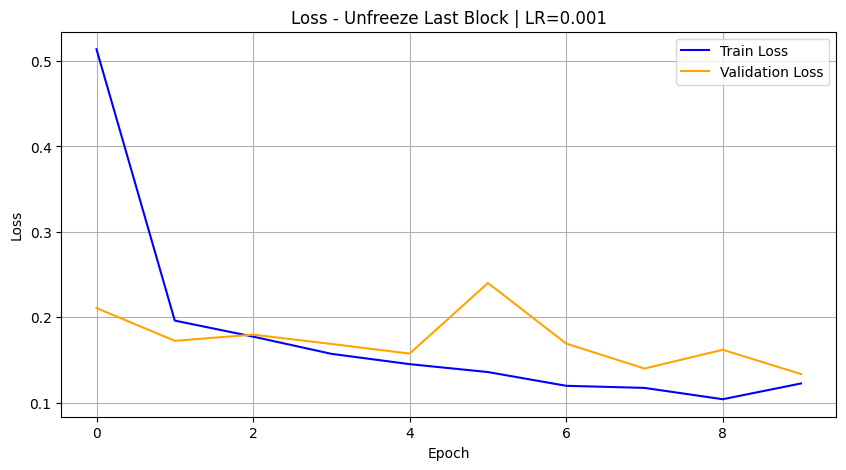

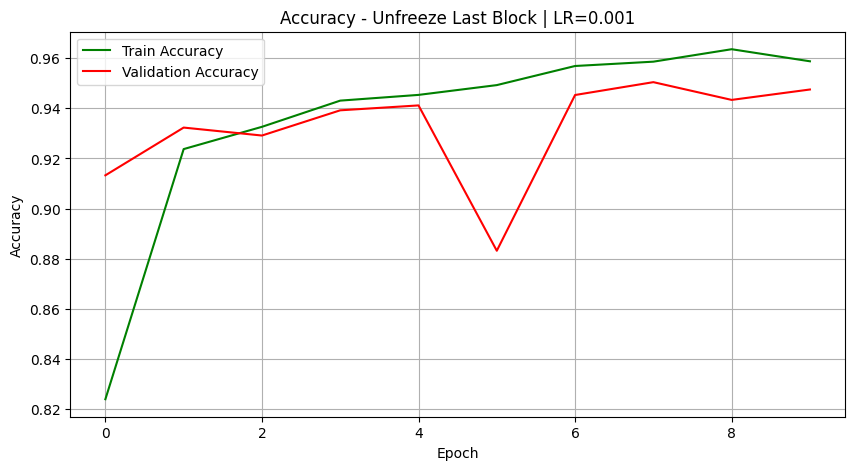

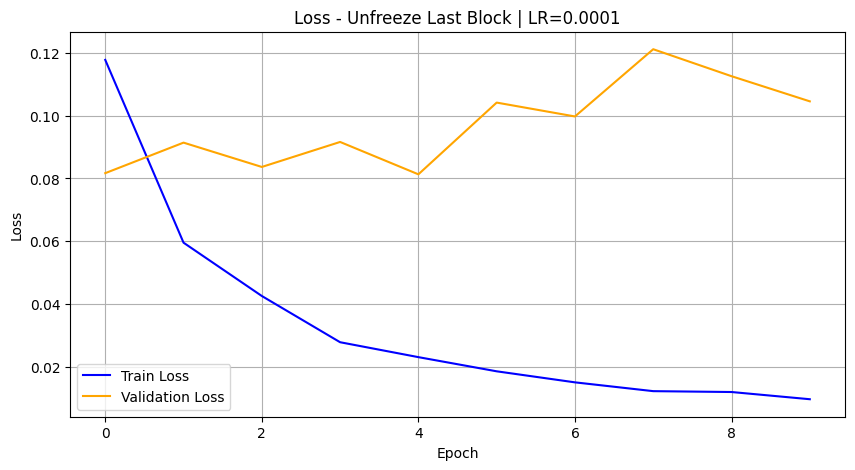

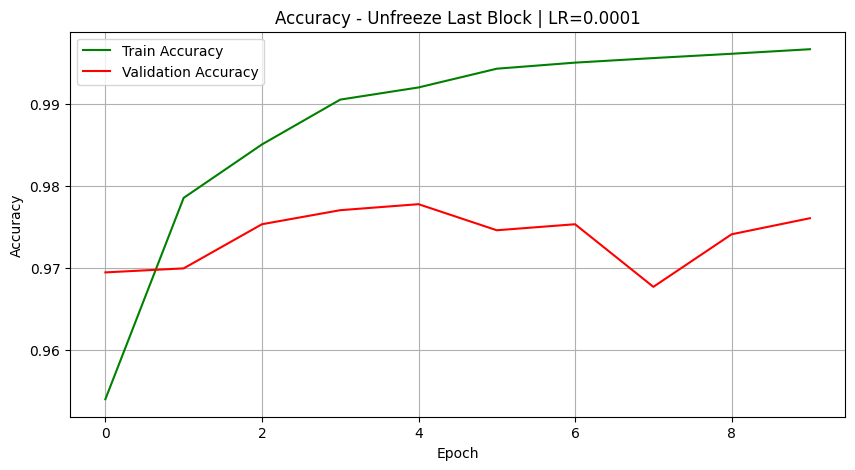

In [21]:
def plot_results(strategy_results, strategy_name):
    for lr, res in strategy_results.items():
        train_losses = res["train_losses"]
        val_losses = res["val_losses"]
        train_acc = res["train_accuracies"]
        val_acc = res["val_accuracies"]

        # Plot Loss
        plt.figure(figsize=(10,5))
        plt.plot(train_losses, label="Train Loss", color='blue')
        plt.plot(val_losses, label="Validation Loss", color='orange')
        plt.title(f"Loss - {strategy_name} | LR={lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Accuracy
        plt.figure(figsize=(10,5))
        plt.plot(train_acc, label="Train Accuracy", color='green')
        plt.plot(val_acc, label="Validation Accuracy", color='red')
        plt.title(f"Accuracy - {strategy_name} | LR={lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call for each strategy
# Plot the results of the Strategy 1 (Freeze All)
# Plot the results of the Strategy 2 (Unfreeze Last Block)
plot_results(results_frozen, "Freeze All")
plot_results(results_last_block, "Unfreeze Last Block")

## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.
- Show the plot of the Test Loss and the Test Accuracy

In [23]:
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [24]:
test_dataset = CelebADataset(test_data[['image_id', 'Male']], img_dir, transform=val_transforms)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

def evaluate_on_test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs)
            preds = preds > 0.5

            correct += (preds.long().squeeze() == labels).sum().item()
            total += labels.size(0)
            test_loss += loss.item()

    test_accuracy = correct / total
    avg_test_loss = test_loss / len(test_loader)

    return avg_test_loss, test_accuracy


# Use the function evaluate_on_test to plot the results


In [25]:
print("\nEvaluating on Test Set")
print("="*60)

# Evaluar modelos con estrategia 'frozen'
for lr, res in results_frozen.items():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1),
    )
    model.load_state_dict(res["model"])
    model = model.to(device)

    avg_test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f"[Freeze All | LR={lr}] Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Evaluar modelos con estrategia 'last_block'
for lr, res in results_last_block.items():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    # Reemplazar el classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1),
    )
    # Descongelar último bloque para ser consistente con entrenamiento
    for param in model.features[24:].parameters():
        param.requires_grad = True

    model.load_state_dict(res["model"])
    model = model.to(device)

    avg_test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f"[Unfreeze Last Block | LR={lr}] Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Evaluating on Test Set
[Freeze All | LR=0.001] Test Loss: 0.1483, Test Acc: 0.9603
[Freeze All | LR=0.0001] Test Loss: 0.1726, Test Acc: 0.9625
[Unfreeze Last Block | LR=0.001] Test Loss: 0.1369, Test Acc: 0.9506
[Unfreeze Last Block | LR=0.0001] Test Loss: 0.0974, Test Acc: 0.9790


In [26]:
print("\nEvaluating on Test Set")
print("="*60)

# Evaluar modelos con estrategia 'frozen'
for lr, res in results_frozen.items():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1),
    )
    model.load_state_dict(res["model"])
    model = model.to(device)

    avg_test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f"[Freeze All | LR={lr}] Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Evaluar modelos con estrategia 'last_block'
for lr, res in results_last_block.items():
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    for param in model.features.parameters():
        param.requires_grad = False
    # Reemplazar el classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 1),
    )
    # Descongelar último bloque para ser consistente con entrenamiento
    for param in model.features[24:].parameters():
        param.requires_grad = True

    model.load_state_dict(res["model"])
    model = model.to(device)

    avg_test_loss, test_accuracy = evaluate_on_test(model, test_loader, device)
    print(f"[Unfreeze Last Block | LR={lr}] Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Evaluating on Test Set
[Freeze All | LR=0.001] Test Loss: 0.1483, Test Acc: 0.9603
[Freeze All | LR=0.0001] Test Loss: 0.1726, Test Acc: 0.9625
[Unfreeze Last Block | LR=0.001] Test Loss: 0.1369, Test Acc: 0.9506
[Unfreeze Last Block | LR=0.0001] Test Loss: 0.0974, Test Acc: 0.9790
